In [249]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import itertools
from skimage import io
import math
import matplotlib.pyplot as plt 
import numpy as np
import os
import pickle
import pandas as pd
from PIL import Image, ImageOps

In [250]:
# Path to folder where images are stored
dataset_dir = "/gpfs/scratch/ms15516/dl4med-project/data/extracted-data/images"

In [251]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Device: {device}")

Device: cuda


In [252]:
# Create datasets:
label_names = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "No Finding", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"]

train_df =  pd.read_csv("../../input/train.csv")
val_df = pd.read_csv("../../input/val.csv")
test_df = pd.read_csv("../../input/test.csv")


In [253]:
import torchvision.models as models

model_resnet = models.resnet50(weights='IMAGENET1K_V2').to(device)

# Remove output layer / classifier layer from model, but save expected size
original_fc_input_size = model_resnet.fc.in_features
model_resnet.fc = nn.Identity ()
num_classes = len(label_names)

In [254]:
class ResNetConcatHiddenState(nn.Module):
    def __init__(self, resnet_model, original_fc_input_size, num_classes):
        super(ResNetConcatHiddenState, self).__init__()
        self.resnet = resnet_model
        self.classifier = nn.Linear(original_fc_input_size + 3, num_classes)  # +3 for age, sex, view

    def forward(self, image, metadata):
        # Get resnet output (ie. final hidden state)
        resnet_output = self.resnet(image)
        # print(f"hidden state shape: {resnet_output.size()}")
        
        # Add metadata
        age = metadata[:, 0].unsqueeze(dim=1)  # Make sure age is of shape (batch_size, 1)
        sex = metadata[:, 1].unsqueeze(dim=1) # Make sure sex is of shape (batch_size, 1)
        view = metadata[:, 2].unsqueeze(dim=1) # Make sure view is of shape (batch_size, 1)

        # Concatenate hidden state with age and sex (assumes sex is already encoded or a scalar)
        combined = torch.cat((resnet_output, age, sex, view), dim=1)
        # print(f"hidden state + metadata shape: {combined.size()}")

        # Classification head
        logits = self.classifier(combined)
        
        return logits


In [255]:
# Load previously trained model from file
model_resnet_trained = ResNetConcatHiddenState(model_resnet, original_fc_input_size, num_classes)
model_resnet_trained.load_state_dict(torch.load('../../output/model_resnet50_linear_weights.pth'))
model_resnet_trained.to(device)

# Load data from the pickle files
with open('../../output/acc_dict_resnet50_linear_weights.pkl', 'rb') as file:
    acc_dict = pickle.load(file)

with open('../../output/loss_dict_resnet50_linear_weights.pkl', 'rb') as file:
    loss_dict = pickle.load(file)

print(acc_dict)
print(loss_dict)

{'train': [0.45661773027492203, 0.4900112721198376, 0.5288081883575751, 0.520799098230413, 0.46896364401830704, 0.4353473759500948, 0.543748953141481, 0.5398937976179159, 0.5539164957740867, 0.5740007876903019, 0.5711786834707264, 0.5984762266918365, 0.6108311943467376, 0.6254378697956985, 0.6319856586041585, 0.6377294600699868, 0.6493610201947496, 0.6555828681886292, 0.6633085708853368, 0.6685381101770492], 'validate': [0.4732811005093993, 0.47650298657978435, 0.471972694127686, 0.45779742973133714, 0.5179065497892587, 0.5041398391642748, 0.6314948413621907, 0.577638145476172, 0.5540299433713444, 0.6561373568122463, 0.4923848679957593, 0.6357096682439946, 0.6502624570113515, 0.6310604297571949, 0.618953792051302, 0.6354976340082228, 0.6035425232074056, 0.6494194916349908, 0.6830967341556125, 0.6373852558632638]}
{'train': [0.08580008624380876, 0.08516689544098602, 0.08459338637462385, 0.08487342964697928, 0.08475258543671403, 0.08466549069399668, 0.08364268656158493, 0.082347255599421

In [256]:
avg_age = train_df['Patient Age'].mean()
std_age = train_df['Patient Age'].std()

def normalize_age(age):
    return (age - avg_age) / std_age

In [257]:
class ChestXrayDataset(Dataset):
    def __init__(self, df, label_names, image_dir, transform):

        self.df = df.reset_index(drop=True)
        # print(self.df.head())
        # print(self.df.columns)
        
        self.image_dir = image_dir
        self.transform = transform
        self.labels = df[label_names].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        # Extract and normalize metadata
        metadata = self.df.loc[idx, ['Patient Age', 'Patient Sex', 'View Position']].to_list()
        metadata[0] = normalize_age(metadata[0])
        metadata[1] = 1 if metadata[1] == 'M' else 0
        metadata[2] = 1 if metadata[2] == 'AP' else 0
        metadata = torch.tensor(metadata).float()
        
        # Load and process the image
        img_name = self.df.loc[idx, "Image Index"]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        image = self.transform(image)

        label = torch.tensor(self.labels[idx]).float()
        
        return image, metadata, label


In [258]:
# -----------------------------
# Transforms
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    # Normalize to the mean and standard deviation for each channel in ImageNet Dataset
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Normalize to the mean and standard deviation for each channel in ImageNet Dataset
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


 - - - - Sample Image Pixel Values - - - - 
tensor([[[[-1.4843, -1.6042, -1.7240,  ...,  0.0912, -0.0116, -0.1143],
          [-1.4672, -1.5870, -1.7069,  ..., -0.1828, -0.3027, -0.3883],
          [-1.5185, -1.6384, -1.7412,  ..., -0.6965, -0.7137, -0.7822],
          ...,
          [-0.6109, -0.5767, -0.6109,  ..., -0.8335,  0.0741,  0.7762],
          [ 0.4508,  0.5536,  0.5022,  ..., -0.7822,  0.1083,  0.7419],
          [ 0.7762,  0.9132,  0.8789,  ..., -0.8335,  0.0056,  0.5878]],

         [[-1.3880, -1.5105, -1.6331,  ...,  0.2227,  0.1176,  0.0126],
          [-1.3704, -1.4930, -1.6155,  ..., -0.0574, -0.1800, -0.2675],
          [-1.4230, -1.5455, -1.6506,  ..., -0.5826, -0.6001, -0.6702],
          ...,
          [-0.4951, -0.4601, -0.4951,  ..., -0.7227,  0.2052,  0.9230],
          [ 0.5903,  0.6954,  0.6429,  ..., -0.6702,  0.2402,  0.8880],
          [ 0.9230,  1.0630,  1.0280,  ..., -0.7227,  0.1352,  0.7304]],

         [[-1.1596, -1.2816, -1.4036,  ...,  0.4439,  0.33

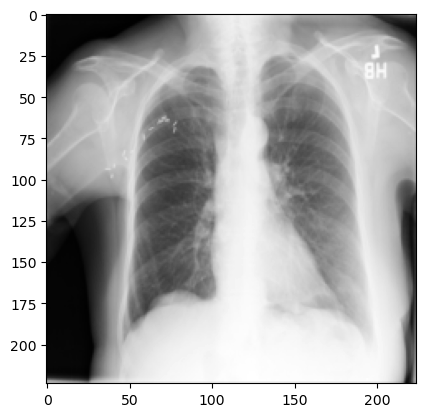

In [259]:
train_ds = ChestXrayDataset(train_df, label_names, dataset_dir, train_transform)
val_ds = ChestXrayDataset(val_df, label_names, dataset_dir, val_test_transform)
test_ds = ChestXrayDataset(test_df, label_names, dataset_dir, val_test_transform)

# Create dataloaders:
train_loader = DataLoader(train_ds, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size = 32)
test_loader = DataLoader(test_ds, batch_size = 32)

# Check that dataloader works as expected:
torch.manual_seed(123)
temp_data = next(iter(test_loader))

temp_img = temp_data[0]
temp_metadata = temp_data[1]
temp_label = temp_data[2]

print(" - - - - Sample Image Pixel Values - - - - ")
print(temp_img)
print(" - - - - - - - - - ")
print(f"temp_img shape: {temp_img.shape}")
plt.imshow(temp_img[0,0,:,:], cmap='gray')
print(f"temp_metadata: {temp_metadata[0]}")
print(f"temp_label shape: {temp_label.shape}")
print(f"temp_label: {temp_label[0]}")

In [260]:
print(f"Number of imges in training dataset: {len(train_ds)}")
print(f"Number of imges in validation dataset: {len(val_ds)}")
print(f"Number of imges in test dataset: {len(test_ds)}")

Number of imges in training dataset: 73633
Number of imges in validation dataset: 12891
Number of imges in test dataset: 25596


In [291]:
train_df_totals = train_df[label_names].sum()/len(train_df)*100

print(f"Percentage of positive cases in training dataset:")
train_df_totals


Percentage of positive cases in training dataset:


Atelectasis            9.434628
Cardiomegaly           1.985523
Consolidation          3.259408
Edema                  1.613407
Effusion               9.952060
Emphysema              1.628346
Fibrosis               1.435498
Hernia                 0.169761
Infiltration          15.943938
Mass                   4.679967
No Finding            58.475140
Nodule                 5.460867
Pleural_Thickening     2.577649
Pneumonia              1.021281
Pneumothorax           3.019027
dtype: float64

In [292]:
val_df_totals = val_df[label_names].sum()/len(val_df)*100

print(f"Percentage of positive cases in validation dataset:")
val_df_totals

Percentage of positive cases in validation dataset:


Atelectasis           10.340548
Cardiomegaly           1.900551
Consolidation          3.506322
Edema                  1.473897
Effusion              10.325033
Emphysema              1.737646
Fibrosis               1.504926
Hernia                 0.124118
Infiltration          15.840509
Mass                   4.561322
No Finding            57.737957
Nodule                 5.329300
Pleural_Thickening     2.668528
Pneumonia              0.961911
Pneumothorax           3.211543
dtype: float64

In [293]:
test_df_totals = test_df[label_names].sum()/len(test_df)*100

print(f"Percentage of positive cases in testing dataset:")
test_df_totals

Percentage of positive cases in testing dataset:


Atelectasis           12.810595
Cardiomegaly           4.176434
Consolidation          7.090952
Edema                  3.613846
Effusion              18.198156
Emphysema              4.270198
Fibrosis               1.699484
Hernia                 0.335990
Infiltration          23.878731
Mass                   6.829192
No Finding            38.525551
Nodule                 6.340835
Pleural_Thickening     4.465541
Pneumonia              2.168308
Pneumothorax          10.411783
dtype: float64

In [263]:
# Define functions to plot accuracy and loss over training epochs

def plot_loss(ax, loss, title):
    x = np.arange(1, len(loss)+1)
    # plt.figure(dpi=150)
    ax.plot(x, loss)
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    # plt.show()

def plot_accuracy(ax, accuracy, title):
    x = np.arange(1, len(accuracy)+1)
    # plt.figure(dpi=150)
    ax.plot(x, accuracy)
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    # plt.show()

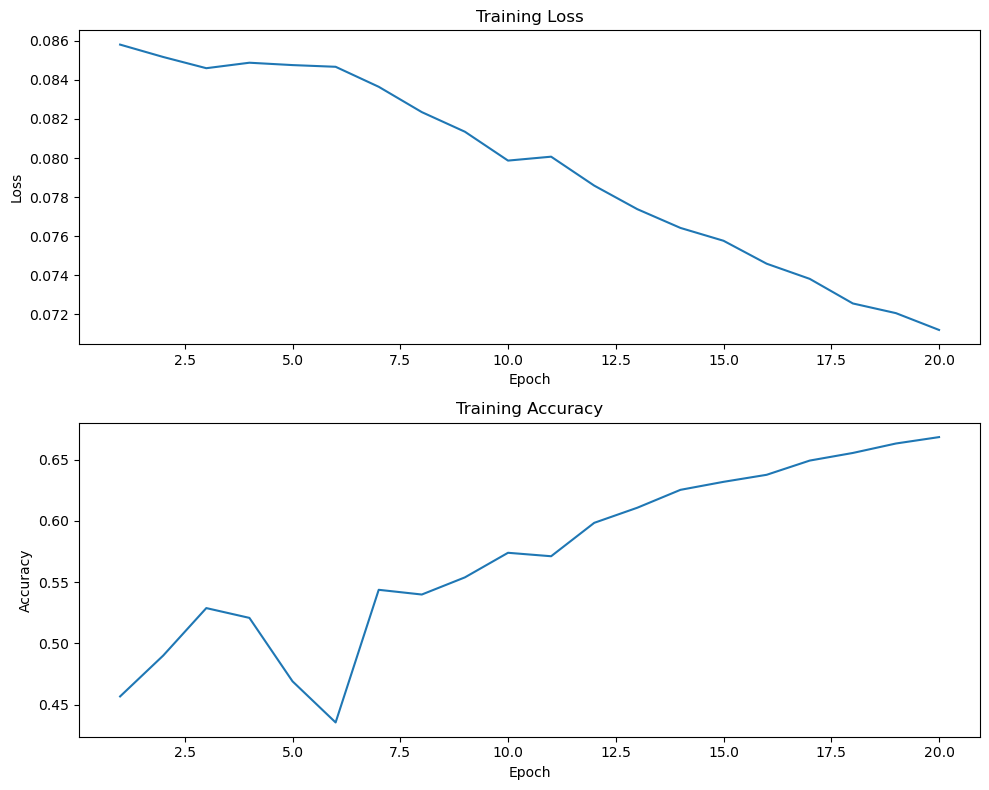

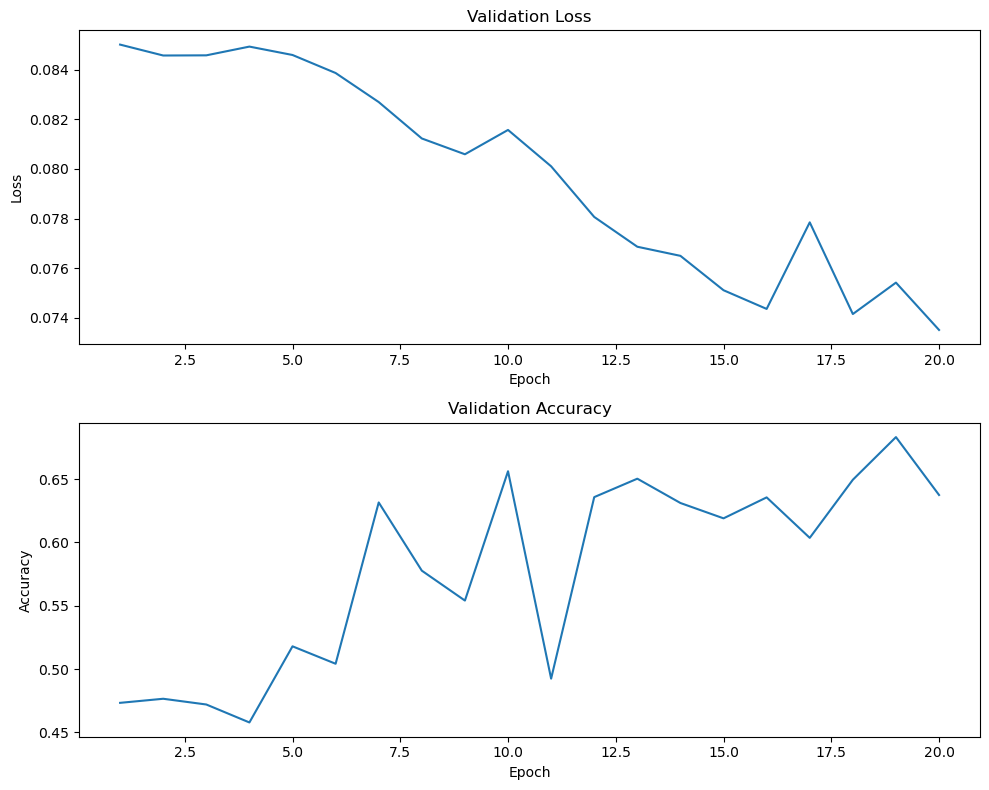

In [264]:
# Visualize the progression of loss and accuracy values during training:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_loss(axes[0], loss_dict['train'], 'Training Loss')
plot_accuracy(axes[1], acc_dict['train'], 'Training Accuracy')

fig.tight_layout()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_loss(axes[0], loss_dict['validate'], 'Validation Loss')
plot_accuracy(axes[1], acc_dict['validate'], 'Validation Accuracy')

fig.tight_layout()

In [265]:
# Create modified version of train_model function, which includes sending back all predicted labels (needed to calcualte AUC metric later)
def evaluate_model(model, dataloader,loss_fn, phase = 'validate'):
    
    model.eval()
    
    running_correct = 0
    running_loss = 0
    running_total = 0
    batch_counter = 0
    total_batches = len(dataloader[phase])
    
    all_labels = []
    all_probs = []
    all_preds = []
    
    with torch.no_grad():  # Disable gradient tracking
        for data in dataloader[phase]:
            print(f"Batch {batch_counter}/{total_batches}")
            batch_counter += 1
            image = data[0].to(device)
            metadata = data[1].to(device)
            label = data[2].to(device)
            output = model(image, metadata)
            loss = loss_fn(output, label)
            probs = nn.functional.sigmoid(output)
            preds = torch.round(probs)
            num_imgs = image.size()[0]
            running_correct += torch.sum(preds ==label).item()
            running_loss += loss.item()*num_imgs
            num_classes = label.size()[1]
            running_total += num_imgs*num_classes
    
            # print(f"probs shape: {probs.size()}")
            # print(f"label shape: {label.size()}")
            # print(f"preds shape: {preds.size()}")

            all_labels.append(label.cpu())
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
        
    accuracy = float(running_correct/running_total)
    loss = float(running_loss/running_total)

    all_labels = torch.cat(all_labels, dim=0)
    all_probs = torch.cat(all_probs, dim=0)
    all_preds = torch.cat(all_preds, dim=0)

    print(f"all_labels shape: {all_labels.size()}")
    print(f"all_probs shape: {all_probs.size()}")
    print(f"all_preds shape: {all_preds.size()}")
    
    return all_preds, all_labels, all_probs, accuracy, loss

In [266]:
train_df_weights = (100-train_df_totals) / train_df_totals

print(train_df_weights)

Atelectasis             9.599251
Cardiomegaly           49.364569
Consolidation          29.680417
Edema                  60.980640
Effusion                9.048171
Emphysema              60.412010
Fibrosis               68.662252
Hernia                588.064000
Infiltration            5.271976
Mass                   20.367673
No Finding              0.710128
Nodule                 17.312111
Pleural_Thickening     37.795047
Pneumonia              96.916223
Pneumothorax           32.123257
dtype: float64


In [267]:
def compute_log_pos_weight(train_df, label_names, max_cap=20.0):
    num_samples = len(train_df)
    # print(f"num_samples: {num_samples}")
    num_labels = len(label_names)
    # print(f"num_labels: {num_labels}")
    label_counts = train_df[label_names].sum()
    # print(f"label_counts: {label_counts}")
    # Avoid divide-by-zero and smooth
    weights = (num_samples - label_counts) / (label_counts + 1e-6)
    # print(f"weights: {weights}")
    # Apply log scale and cap
    weights = np.minimum(np.log1p(weights), max_cap)
    # print(f"weights: {weights}")
    return torch.tensor(weights, dtype=torch.float32)


In [268]:
class_weights_raw = torch.tensor(train_df_weights, dtype=torch.float32)
print(class_weights_raw)
class_weights_log = compute_log_pos_weight(train_df, label_names)
print(class_weights_log)

class_pos_weights = torch.tensor(class_weights_raw).to(device)

tensor([  9.5993,  49.3646,  29.6804,  60.9806,   9.0482,  60.4120,  68.6623,
        588.0640,   5.2720,  20.3677,   0.7101,  17.3121,  37.7950,  96.9162,
         32.1233])
tensor([2.3608, 3.9193, 3.4236, 4.1268, 2.3074, 4.1176, 4.2437, 6.3785, 1.8361,
        3.0619, 0.5366, 2.9076, 3.6583, 4.5841, 3.5002])


/tmp/ipykernel_3621494/1149019516.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights_raw = torch.tensor(train_df_weights, dtype=torch.float32)
/tmp/ipykernel_3621494/432158385.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(weights, dtype=torch.float32)
/tmp/ipykernel_3621494/1149019516.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_pos_weights = torch.tensor(class_weights_raw).to(device)


In [269]:
# # Predict labels for validation dataset using model:
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_pos_weights)
# eval_dataloader = {'test': val_loader}

# val_preds_list, val_labels_list, val_probs_list, val_accuracy, val_loss = evaluate_model(model_resnet_trained, eval_dataloader, loss_fn, 'test')


In [270]:
# # - - - Save results to files - - -
# with open('../../output/inference_results/val_preds_resnet50_linear_weights.pkl', 'wb') as f:
#     pickle.dump(val_preds_list, f)

# with open('../../output/inference_results/val_labels_resnet50_linear_weights.pkl', 'wb') as f:
#     pickle.dump(val_labels_list, f)

# with open('../../output/inference_results/val_probs_resnet50_linear_weights.pkl', 'wb') as f:
#     pickle.dump(val_probs_list, f)

# with open('../../output/inference_results/val_accuracy_resnet50_linear_weights.pkl', 'wb') as f:
#     pickle.dump(val_accuracy, f)

# with open('../../output/inference_results/val_loss_resnet50_linear_weights.pkl', 'wb') as f:
#     pickle.dump(val_loss, f)

In [271]:
# Load data from the pickle files
with open('../../output/inference_results/val_preds_resnet50_linear_weights.pkl', 'rb') as f:
    val_preds_list = pickle.load(f)

with open('../../output/inference_results/val_labels_resnet50_linear_weights.pkl', 'rb') as f:
    val_labels_list = pickle.load(f)

with open('../../output/inference_results/val_probs_resnet50_linear_weights.pkl', 'rb') as f:
    val_probs_list = pickle.load(f)

with open('../../output/inference_results/val_accuracy_resnet50_linear_weights.pkl', 'rb') as f:
    val_accuracy = pickle.load(f)

with open('../../output/inference_results/val_loss_resnet50_linear_weights.pkl', 'rb') as f:
    val_loss = pickle.load(f)

In [272]:
# # Predict labels for testing dataset using model:
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_pos_weights)
# eval_dataloader = {'test': test_loader}

# test_preds_list, test_labels_list, test_probs_list, test_accuracy, test_loss = evaluate_model(model_resnet_trained, eval_dataloader, loss_fn, 'test')


In [273]:
# # - - - Save results to files - - -
# with open('../../output/inference_results/test_preds_resnet50_linear_weights.pkl', 'wb') as f:
#     pickle.dump(test_preds_list, f)

# with open('../../output/inference_results/test_labels_resnet50_linear_weights.pkl', 'wb') as f:
#     pickle.dump(test_labels_list, f)

# with open('../../output/inference_results/test_probs_resnet50_linear_weights.pkl', 'wb') as f:
#     pickle.dump(test_probs_list, f)

# with open('../../output/inference_results/test_accuracy_resnet50_linear_weights.pkl', 'wb') as f:
#     pickle.dump(test_accuracy, f)

# with open('../../output/inference_results/test_loss_resnet50_linear_weights.pkl', 'wb') as f:
#     pickle.dump(test_loss, f)

In [274]:
# Load data from the pickle files
with open('../../output/inference_results/test_preds_resnet50_linear_weights.pkl', 'rb') as f:
    test_preds_list = pickle.load(f)

with open('../../output/inference_results/test_labels_resnet50_linear_weights.pkl', 'rb') as f:
    test_labels_list = pickle.load(f)

with open('../../output/inference_results/test_probs_resnet50_linear_weights.pkl', 'rb') as f:
    test_probs_list = pickle.load(f)

with open('../../output/inference_results/test_accuracy_resnet50_linear_weights.pkl', 'rb') as f:
    test_accuracy = pickle.load(f)

with open('../../output/inference_results/test_loss_resnet50_linear_weights.pkl', 'rb') as f:
    test_loss = pickle.load(f)

In [275]:
results_dict = {}

for idx, label in enumerate(label_names):
    results_dict[f"predicted_{label}"] = test_preds_list[:,idx].bool()
    results_dict[f"label_{label}"] = test_labels_list[:,idx].bool()
    results_dict[f"prob_{label}"] = test_probs_list[:,idx]

results_df = pd.DataFrame(results_dict)
print(results_df)

       predicted_Atelectasis  label_Atelectasis  prob_Atelectasis  \
0                      False              False          0.272023   
1                       True              False          0.640087   
2                       True              False          0.770187   
3                       True              False          0.654147   
4                       True              False          0.764479   
...                      ...                ...               ...   
25591                  False              False          0.161107   
25592                  False              False          0.264147   
25593                  False              False          0.085925   
25594                  False              False          0.143303   
25595                  False              False          0.182030   

       predicted_Cardiomegaly  label_Cardiomegaly  prob_Cardiomegaly  \
0                       False               False           0.112913   
1                       Fal

In [276]:
from sklearn.metrics import recall_score, precision_score, f1_score

y_true = test_labels_list.numpy().astype(int)
print(y_true)

y_pred = test_preds_list.numpy().astype(int)
print(y_pred)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 1 0 1]
 [1 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [277]:
# Compute recall: tp / (tp + fn)
recall_per_class = recall_score(y_true, y_pred, average=None)  # or 'macro' or 'micro', 'samples', 'weighted'
# print("Recall score:", recall)

# Compute precision: tp / (tp + fp)
precision_per_class = precision_score(y_true, y_pred, average=None)

# Compute F-1 score: tp / (tp + fp)
f1score_per_class = f1_score(y_true, y_pred, average=None)

df_class_scores = pd.DataFrame(columns=label_names, index=['Recall','Precision','F-1 Score'])

df_class_scores.loc['Recall'] = recall_per_class
df_class_scores.loc['Precision'] = precision_per_class
df_class_scores.loc['F-1 Score'] = f1score_per_class

# Display dataframe:
df_class_scores

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Recall,0.834096,0.891487,0.916804,0.955676,0.919064,0.849039,0.629885,0.534884,0.901342,0.752288,0.368117,0.716574,0.743657,0.913514,0.845779
Precision,0.161672,0.069163,0.09204,0.05228,0.240749,0.060551,0.037153,0.010517,0.266599,0.087708,0.662409,0.07726,0.063685,0.024961,0.152051
F-1 Score,0.270846,0.128367,0.167287,0.099136,0.381551,0.11304,0.070166,0.020628,0.411488,0.157099,0.473242,0.139482,0.117322,0.048593,0.257762


In [290]:
# Macro
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1score_macro = f1_score(y_true, y_pred, average='macro')

# Micro
recall_micro = recall_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
f1score_micro = f1_score(y_true, y_pred, average='micro')

# Weighted
recall_weighted = recall_score(y_true, y_pred, average='weighted')
precision_weighted = precision_score(y_true, y_pred, average='weighted')
f1score_weighted = f1_score(y_true, y_pred, average='weighted')

data = {'Macro' : [recall_macro, precision_macro, f1score_macro], 'Micro': [recall_micro, precision_micro, f1score_micro], 'Weighted': [recall_weighted, precision_weighted, f1score_weighted]}
df_avg_scores = pd.DataFrame(data, index=['Recall','Precision','F-1 Score'])
df_avg_scores.round({'Macro': 4, 'Micro': 4, 'Weighted': 4})

,Macro,Micro,Weighted
Recall,0.7848,0.7282,0.7282
Precision,0.1373,0.1254,0.2956
F-1 Score,0.1904,0.2140,0.3206


In [279]:
test_df_totals = test_df[label_names].sum()/len(test_df)*100

print(f"Percentage of positive cases in testing dataset:")
test_df_totals

Percentage of positive cases in testing dataset:


Atelectasis           12.810595
Cardiomegaly           4.176434
Consolidation          7.090952
Edema                  3.613846
Effusion              18.198156
Emphysema              4.270198
Fibrosis               1.699484
Hernia                 0.335990
Infiltration          23.878731
Mass                   6.829192
No Finding            38.525551
Nodule                 6.340835
Pleural_Thickening     4.465541
Pneumonia              2.168308
Pneumothorax          10.411783
dtype: float64

In [280]:
columns = ["predicted_" + s for s in label_names]

preds_df_totals = results_df[columns].sum()/len(results_df)*100

print(f"Percentage of predicted positive cases for the testing dataset:")
preds_df_totals

Percentage of predicted positive cases for the testing dataset:


predicted_Atelectasis           66.092358
predicted_Cardiomegaly          53.832630
predicted_Consolidation         70.632130
predicted_Edema                 66.061103
predicted_Effusion              69.471792
predicted_Emphysema             59.876543
predicted_Fibrosis              28.813096
predicted_Hernia                17.088608
predicted_Infiltration          80.731364
predicted_Mass                  58.575559
predicted_No Finding            21.409595
predicted_Nodule                58.809970
predicted_Pleural_Thickening    52.144866
predicted_Pneumonia             79.356149
predicted_Pneumothorax          57.915299
dtype: float64

In [281]:
# exact match ratio
exact_correct = np.all(y_true == y_pred, axis=1)
print(f"Exact match ratio: {sum(exact_correct)/len(test_ds):.4f}%")

Exact match ratio: 0.0360%


In [282]:
# Calculate optimal operating point thresholds based on validation dataset:

from sklearn.metrics import precision_recall_curve, f1_score

num_labels = len(label_names)

probs = val_probs_list.numpy()
labels = val_labels_list.numpy().astype(int)

# Before threshold tuning:
preds = (probs >= 0.5).astype(int)
f1_macro = f1_score(labels, preds, average='macro')
f1_micro = f1_score(labels, preds, average='micro')
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Micro: {f1_micro:.4f}")

# Find optimal threshold per label using PR curve + F1
optimal_thresholds = []
for i in range(num_labels):
    precision, recall, thresholds = precision_recall_curve(labels[:, i], probs[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    optimal_thresholds.append(best_threshold)

optimal_thresholds = np.array(optimal_thresholds)
print("Optimal thresholds per label:", optimal_thresholds)

# Apply thresholds for updated predictions
preds = (probs >= optimal_thresholds).astype(int)

# Evaluate F1 score after threshold tuning
f1_macro = f1_score(labels, preds, average='macro')
f1_micro = f1_score(labels, preds, average='micro')
print(f"F1 Macro (tuned): {f1_macro:.4f}")
print(f"F1 Micro (tuned): {f1_micro:.4f}")


F1 Macro: 0.1712
F1 Micro: 0.2362
Optimal thresholds per label: [0.6188085  0.89670604 0.7894732  0.8657349  0.71364677 0.75782627
 0.72108483 0.9818003  0.56799555 0.7028118  0.2491528  0.66044253
 0.70194197 0.76483077 0.70966434]
F1 Macro (tuned): 0.2130
F1 Micro (tuned): 0.4452


In [283]:
def predict_with_thresholds(probs, thresholds):
    adjusted_predictions = (probs >= torch.tensor(thresholds, device=probs.device)).float()
    
    return adjusted_predictions

In [284]:
# Recalculate results for test dataset
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
print(f"F1 Macro (original): {f1_macro:.4f}")
print(f"F1 Micro (original): {f1_micro:.4f}")

test_preds_list_tuned = predict_with_thresholds(test_probs_list, optimal_thresholds)
y_pred_tuned = test_preds_list_tuned.numpy().astype(int)

f1_macro = f1_score(y_true, y_pred_tuned, average='macro')
f1_micro = f1_score(y_true, y_pred_tuned, average='micro')
print(f"F1 Macro (tuned): {f1_macro:.4f}")
print(f"F1 Micro (tuned): {f1_micro:.4f}")

F1 Macro (original): 0.1904
F1 Micro (original): 0.2140
F1 Macro (tuned): 0.2236
F1 Micro (tuned): 0.3387


In [285]:
# Compute recall: tp / (tp + fn)
recall_per_class = recall_score(y_true, y_pred_tuned, average=None)  # or 'macro' or 'micro', 'samples', 'weighted'
# print("Recall score:", recall)

# Compute precision: tp / (tp + fp)
precision_per_class = precision_score(y_true, y_pred_tuned, average=None)

# Compute F-1 score: tp / (tp + fp)
f1score_per_class = f1_score(y_true, y_pred_tuned, average=None)

df_class_scores_tuned = pd.DataFrame(columns=label_names, index=['Recall','Precision','F-1 Score'])

df_class_scores_tuned.loc['Recall'] = recall_per_class
df_class_scores_tuned.loc['Precision'] = precision_per_class
df_class_scores_tuned.loc['F-1 Score'] = f1score_per_class

# Display dataframe:
df_class_scores_tuned

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Recall,0.591644,0.15435,0.3427,0.432432,0.708673,0.26258,0.17931,0.023256,0.807919,0.313501,0.723456,0.261861,0.335083,0.263063,0.412758
Precision,0.198141,0.385514,0.13092,0.087758,0.291917,0.101773,0.050323,0.133333,0.295547,0.125171,0.474461,0.102139,0.087503,0.028018,0.238612
F-1 Score,0.296863,0.220441,0.189461,0.145906,0.413504,0.146691,0.078589,0.039604,0.432778,0.17891,0.573081,0.146957,0.138768,0.050642,0.302405


In [286]:
# Macro
recall_macro = recall_score(y_true, y_pred_tuned, average='macro')
precision_macro = precision_score(y_true, y_pred_tuned, average='macro')
f1score_macro = f1_score(y_true, y_pred_tuned, average='macro')

# Micro
recall_micro = recall_score(y_true, y_pred_tuned, average='micro')
precision_micro = precision_score(y_true, y_pred_tuned, average='micro')
f1score_micro = f1_score(y_true, y_pred_tuned, average='micro')

# Weighted
recall_weighted = recall_score(y_true, y_pred_tuned, average='weighted')
precision_weighted = precision_score(y_true, y_pred_tuned, average='weighted')
f1score_weighted = f1_score(y_true, y_pred_tuned, average='weighted')

data = {'Macro' : [recall_macro, precision_macro, f1score_macro], 'Micro': [recall_micro, precision_micro, f1score_micro], 'Weighted': [recall_weighted, precision_weighted, f1score_weighted]}
df_avg_scores_tuned = pd.DataFrame(data, index=['Recall','Precision','F-1 Score'])
df_avg_scores_tuned.round({'Macro': 4, 'Micro': 4, 'Weighted': 4})

,Macro,Micro,Weighted
Recall,0.3875,0.5792,0.5792
Precision,0.1821,0.2393,0.2834
F-1 Score,0.2236,0.3387,0.3683


In [287]:
# Calculate AUC-ROC:

from sklearn.metrics import roc_auc_score

# y_true: [batch_size, num_labels], binary (0 or 1)
# y_pred: [batch_size, num_labels], probabilities from model (sigmoid output)

y_probs = test_probs_list

macro_auc = roc_auc_score(y_true, y_probs, average='macro')
micro_auc = roc_auc_score(y_true, y_probs, average='micro')
weighted_auc = roc_auc_score(y_true, y_probs, average='weighted')

print("Macro AUC:", macro_auc)
print("Micro AUC:", micro_auc)
print("Weighted AUC:", weighted_auc)


Macro AUC: 0.6912166543784756
Micro AUC: 0.6290062308304473
Weighted AUC: 0.6837504233469454


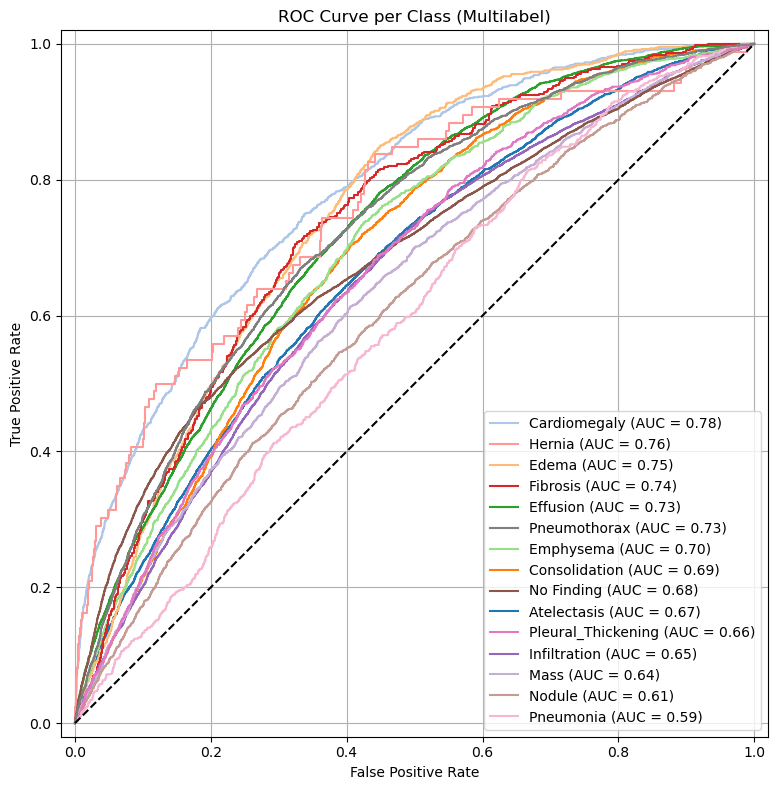

In [288]:
# Plot ROC curves:

from sklearn.metrics import roc_curve, auc

# Plotting setup
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
cmap=plt.get_cmap('tab20')

roc_auc_list = []

for i in range(num_labels):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_names[i]} (AUC = {roc_auc:.2f})", color=cmap(i))
    roc_auc_list.append(roc_auc)

# Chance line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
ax.set_aspect('equal')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class (Multilabel)')

plt.legend(loc='lower right')
handles, labels = plt.gca().get_legend_handles_labels()
order = np.argsort(roc_auc_list)[::-1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])


plt.grid(True)
plt.tight_layout()
plt.savefig('../../output/inference_results/model_resnet50_linear_weights_roc_auc.png', dpi=300)
plt.show()


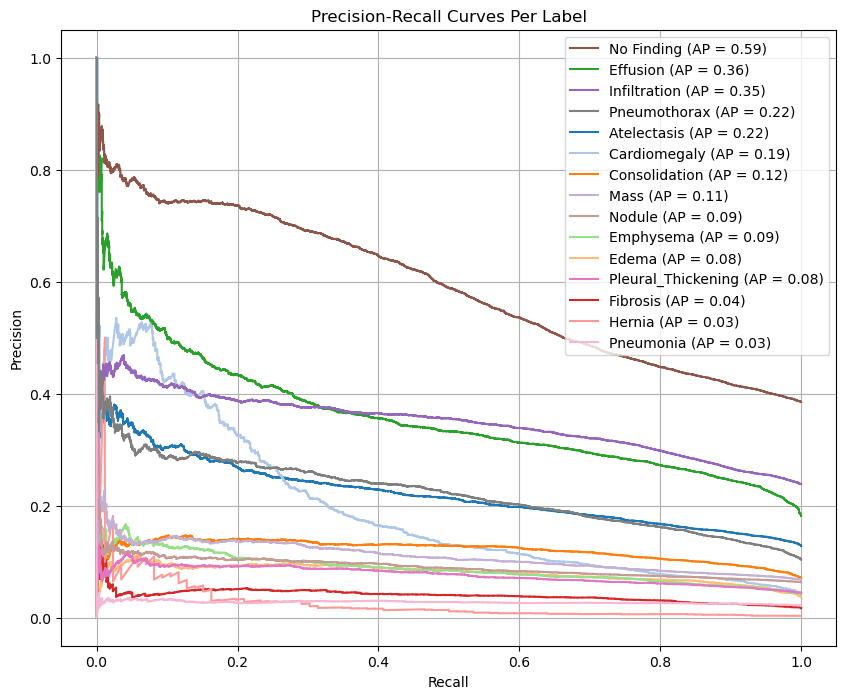

In [289]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Create a figure
plt.figure(figsize=(10, 8))
cmap=plt.get_cmap('tab20')
ap_score_list = []

for i in range(num_labels):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    ap_score = average_precision_score(y_true[:, i], y_probs[:, i])
    ap_score_list.append(ap_score)
    
    plt.plot(recall, precision, label=f'{label_names[i]} (AP = {ap_score:.2f})', color=cmap(i))

# Plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves Per Label')

plt.legend(loc='best')
handles, labels = plt.gca().get_legend_handles_labels()
order = np.argsort(ap_score_list)[::-1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.grid(True)
plt.savefig('../../output/inference_results/model_resnet50_linear_weights_prc_ap.png', dpi=300)
plt.show()